# Quadrotor (aka "the drone")

By Eugene Lim and Ashish Dhanalakota

This is the code we used to control and simulate our drone, and to plot its motion.

## Setup

The first step is to import all the packages we need. `numpy`, `sympy`, and `scipy` help with creating our initial matrices and finding the K matrices and eigenvalues that we seek to use. `os` and `time` help with the simulation of our drone. `matplotlib` helps with plotting the motion of the drone. `ae353_drone` is needed to run and display the PyBullet simulator we use. `secrets` is needed to generate and use the random seeds we will be using.

In [130]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import secrets
import ae353_drone

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

#deriveEOM imports
import sympy as sym
from scipy import signal
from scipy import linalg
from matplotlib.ticker import MultipleLocator
import matplotlib as mpl
mpl.rcParams["savefig.dpi"] = 2000

## Dynamic model

Define physical parameters.

In [2]:
params = {
    'm': 0.5,
    'Jx': 0.0023,
    'Jy': 0.0023,
    'Jz': 0.0040,
    'l': 0.175,
    'g': 9.81,
} #m is the mass of the drone?

Derive the equations of motion:

In [3]:
# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')
v_in_body = sym.Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')
w_in_body = sym.Matrix([w_x, w_y, w_z])

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(params['m'])
Jx = sym.nsimplify(params['Jx'])
Jy = sym.nsimplify(params['Jy'])
Jz = sym.nsimplify(params['Jz'])
l = sym.nsimplify(params['l'])
g = sym.nsimplify(params['g'])
J = sym.diag(Jx, Jy, Jz)

# rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# applied forces
f_in_body = R_body_in_world.T @ sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [f_z]])

# applied torques
tau_in_body = sym.Matrix([[tau_x], [tau_y], [tau_z]])

# equations of motion
f = sym.Matrix.vstack(
    R_body_in_world @ v_in_body,
    M @ w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    J.inv() @ (tau_in_body - w_in_body.cross(J @ w_in_body)),
)

f = sym.simplify(f, full=True)

The equations of motion have this form:

$$\begin{bmatrix} \dot{p}_x \\ \dot{p}_y \\ \dot{p}_z \\ \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \\ \dot{v}_x \\ \dot{v}_y \\ \dot{v}_z \\ \dot{w}_x \\ \dot{w}_y \\ \dot{w}_z \end{bmatrix} = f\left(p_x, p_y, p_z, \psi, \theta, \phi, v_x, v_y, v_z, w_x, w_y, w_z, \tau_x, \tau_y, \tau_z, f_z \right)$$

Here is the function $f$:

In [4]:
f

Matrix([
[v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) - v_z*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))],
[                                                                      -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                                 (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                              w_y*cos(phi) - w_z*sin(phi)],
[                                                                                  w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                   v_y*w_z - v_z*w_y + 981*sin(theta)/100],
[   

Lambdify to get `f_num`, `m_e`, and `n_e`.

In [5]:
f_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z],f)
#net force should equal weight of the drone
#should only be in tau_z direction
p_x_e, p_y_e, p_z_e, psi_e, theta_e, phi_e, v_x_e, v_y_e, v_z_e, w_x_e, w_y_e, w_z_e, tau_x_e, tau_y_e, tau_z_e, f_z_e = 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,params['m']*params['g']

m_e = [p_x_e, p_y_e, p_z_e, psi_e, theta_e, phi_e, v_x_e, v_y_e, v_z_e, w_x_e, w_y_e, w_z_e]
n_e = [tau_x_e, tau_y_e, tau_z_e, f_z_e]

4.905
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 4.905]


Find the `A` and `B` matrices.

In [6]:
A_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z], f.jacobian([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]))
A = A_num(p_x_e, p_y_e, p_z_e, psi_e, theta_e, phi_e, v_x_e, v_y_e, v_z_e, w_x_e, w_y_e, w_z_e, tau_x_e, tau_y_e, tau_z_e, f_z_e)
sym.Matrix(A)

B_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z], f.jacobian([tau_x, tau_y, tau_z, f_z]))
B = B_num(p_x_e, p_y_e, p_z_e, psi_e, theta_e, phi_e, v_x_e, v_y_e, v_z_e, w_x_e, w_y_e, w_z_e, tau_x_e, tau_y_e, tau_z_e, f_z_e)
print(A.tolist())
print(B.tolist())

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 9.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, -9.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 2.0], [434.7826086956522, 0.0, 0.0, 0.0], [0.0, 434.782

Find `W` to prove that the system is fully controllable.

In [7]:
#we are NOT making W for all 12 states manually so let's do this automatically:
W = B
n = A.shape[0]
# Create W one column at a time by iterating over i from 1 to n-1
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    W = np.block([W, col])

print(np.linalg.matrix_rank(W))

12


Rank of $W$ = 12 = # of states, system is controllable

## Sensor model

Define the sensor model.

In [8]:
# Position of drone in world frame
p_in_world = sym.Matrix([p_x, p_y, p_z])

# Position of markers in body frame
a_in_body = sym.Matrix([l, 0, 0])  # <-- marker on front rotor
b_in_body = sym.Matrix([-l, 0, 0]) # <-- marker on rear rotor

# Position of markers in world frame
a_in_world = p_in_world + R_body_in_world @ a_in_body
b_in_world = p_in_world + R_body_in_world @ b_in_body

# Sensor model
g = sym.simplify(sym.Matrix.vstack(a_in_world, b_in_world))

The sensor model has this form:

$$o = g(p_x, p_y, p_z, \psi, \theta)$$

Here is the function $g$:

In [9]:
g

Matrix([
[p_x + 7*cos(psi)*cos(theta)/40],
[p_y + 7*sin(psi)*cos(theta)/40],
[         p_z - 7*sin(theta)/40],
[p_x - 7*cos(psi)*cos(theta)/40],
[p_y - 7*sin(psi)*cos(theta)/40],
[         p_z + 7*sin(theta)/40]])

Find the drone equilibrium values, or `g_eq`.

In [10]:
g_eq = np.array(g.subs([(p_x, p_x_e), (p_y, p_y_e), (p_z, p_z_e), (psi, psi_e), (theta, theta_e)])).astype(np.float64)
g_eq = g_eq.reshape(6,)
print(g_eq.tolist())

[0.175, 0.0, 0.0, -0.175, 0.0, 0.0]


Find the `C` matrix.

In [11]:
C_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z], g.jacobian([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]))
C = C_num(p_x_e, p_y_e, p_z_e, psi_e, theta_e, phi_e, v_x_e, v_y_e, v_z_e, w_x_e, w_y_e, w_z_e, tau_x_e, tau_y_e, tau_z_e, f_z_e)
sym.Matrix(C)

#D should equal 0, g isn't dependent on n

[[1.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.175, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, -0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, -0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


Find the `W_o` matrix to confirm that the system is fully observable.

In [12]:
W_o = C
n = A.shape[0]
for j in range(1,n):
    row = C@np.linalg.matrix_power(A,j)
    W_o = np.block([[W_o],[row]])
print(np.linalg.matrix_rank(W_o))

12


rank of $W_o$ = # states, thus system observable

Define the `lqr` method for future use.

In [13]:
#from Prof Bretl
def lqr(A,B,Q,R):
    '''
    Returns optimal K matrix given A, B, Q, R matrices
    '''
    P = linalg.solve_continuous_are(A, B, Q, R)
    return linalg.inv(R) @  B.T @ P

Find the gain matrix `K` using the LQR method. Also, print the eigenvalues of `A` - `B` @ `K` to ensure that they are all negative.

In [14]:
Q = np.diag([10, 10, 200, 100, 100, 100, 1, 1, 1, 1, 1, 1])
R = 2500*np.diag([1,1,1,0.004])
K = lqr(A,B,Q,R)

print(linalg.eigvals(A-B@K))

[-7.87061706+4.95751123j -7.87061706-4.95751123j -7.87061706+4.95751123j
 -7.87061706-4.95751123j -5.59016994+4.33012702j -5.59016994-4.33012702j
 -1.33326794+1.15763351j -1.33326794-1.15763351j -1.33326794+1.15763351j
 -1.33326794-1.15763351j -2.13825535+2.09096532j -2.13825535-2.09096532j]


Find the gain matrix `L` using the LQR method. Also, print the eigenvalues of `A` - `L` @ `C` to ensure that they are all negative.

In [16]:
Ro = 2500*np.diag([10, 1, 0.001, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Qo = np.diag([100, 100, 100, 1, 1, 1]) #num rows of C
L = lqr(A.T,C.T,linalg.inv(Ro),linalg.inv(Qo)).T

print(linalg.eigvals(A-L@C))

[-6.35611197+0.j         -0.60259534+1.18388417j -0.60259534-1.18388417j
 -0.03162317+0.j         -1.03871335+0.19597426j -1.03871335-0.19597426j
 -0.60427335+1.17997189j -0.60427335-1.17997189j -1.04161435+0.19229848j
 -1.04161435-0.19229848j -0.05911649+0.05891096j -0.05911649-0.05891096j]


## Controller

Define a controller for the drone.

In [30]:
class Controller:
    def __init__(self):
        self.A = np.array(A, dtype=float)
        self.B = np.array(B, dtype=float)
        self.C = np.array(C, dtype=float)
        self.K = np.array(K, dtype=float)
        self.L = np.array(L, dtype=float)
        
        self.dt = 0.04
        self.emax = 0.8
        self.variables_to_log = ['xhat', 'xdes']
        

    def get_color(self):
        return [
            0., # <-- how much red (between 0 and 1)
            0., # <-- how much green (between 0 and 1)
            1., # <-- how much blue (between 0 and 1)
        ]

    def reset(
            self,
            p_x, p_y, p_z, # <-- approximate initial position of drone (meters)
            yaw,           # <-- approximate initial yaw angle of drone (radians)
        ):
        
        self.xhat = np.array([p_x, p_y, p_z, yaw, 0, 0, 0, 0, 0, 0, 0, 0])
        self.xdes = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        self.t = 0

    def run(
            self,
            pos_markers,
            pos_ring,
            dir_ring,
            is_last_ring,
            pos_others,              

        ):
        """
        pos_markers is a 1d array of length 6:
            [   measured x position of marker on front rotor (meters),
                measured y position of marker on front rotor (meters),
                measured z position of marker on front rotor (meters),
                measured x position of marker on back rotor (meters),
                measured y position of marker on back rotor (meters),
                measured z position of marker on back rotor (meters), ]
        
        pos_ring is a 1d array of length 3:
            [   x position of next ring center (meters),
                y position of next ring center (meters),
                z position of next ring center (meters), ]
        
        dir_ring is a 1d array of length 3:
            [   x component of vector normal to next ring (meters),
                y component of vector normal to next ring (meters),
                z component of vector normal to next ring (meters), ]
        
        is_last_ring is a boolean that is True if the next ring is the
                     last ring, and False otherwise
        
        pos_others is a 2d array of size n x 3, where n is the number of
                   all *other* drones:
            [   [x_1, y_1, z_1], # <-- position of 1st drone (meters)
                [x_2, y_2, z_2], # <-- position of 2nd drone (meters)
                
                ...
                
                [x_n, y_n, z_n], # <-- position of nth drone (meters), ]      
        """
        self.t +=self.dt
        position = np.array([self.xhat[0], self.xhat[1], self.xhat[2]])
        
        if np.linalg.norm(pos_ring - position) < self.emax:
            qdes = pos_ring + 0.7 * dir_ring
        else:
            qdes = position + self.emax*(pos_ring - position)/(np.linalg.norm(pos_ring - position))
        
        u = -self.K @ (self.xhat - np.block([qdes, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
        
        self.xdes = np.block([qdes, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        
        if self.t<1:
            u = np.array([0,0,0,0])
            self.xdes = np.zeros(12)
        
        speed = 1.06
        
        
        f_z = u[3] + f_z_e
        
        if np.linalg.norm(pos_ring - position) > 0.01:
            if self.t<3:
                self.emax = 3
                if np.linalg.norm(pos_ring[:1] - position[:1])>0.65:
                    f_z -= 0.07
                    speed = 1.1
            else:
                self.emax = 4.
        else:
            self.emax = 1.1
        
        tau_x = u[0] * speed
        tau_y = u[1] * speed
        tau_z = u[2] * speed
        
        if pos_ring[2] - pos_markers[2] > 0.3:
            f_z += 0.1
        
        if is_last_ring:
            f_z = -7
        
        y = pos_markers - g_eq
    
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y))
        
        return tau_x, tau_y, tau_z, f_z

# Trial 1: Random Courses

In this trial, 200 simulations will be run with randomly generated courses and initial conditions.

First, we set the number of simulations.

In [19]:
trials = 200

Next, we create arrays to store the data we need for any plots and figures we'd like to make.

In [20]:
times = np.array([])
xhat_x = np.array([])
runtimes = np.array([])
x_xdes = np.array([])
fail_count = 0

We run the simulation by the number of times defined by `trials`.

In [21]:
simulator = ae353_drone.Simulator(
        display=False,
        display_pybullet=False,
        seed=secrets.randbits(32),
    )

for i in range(trials): 
    simulator.clear_drones()
    simulator.add_drone(Controller, 'template', 'template.png')
    simulator.reset()
    simulator.run(max_time=1000.)
    
    (
    did_it_fail,
    did_it_finish,
    what_time_did_it_finish,
    ) = simulator.get_result('template')
    
    data = simulator.get_data('template')
    
    if did_it_fail:
        fail_count += 1
    elif did_it_finish:
        times = np.append(times, what_time_did_it_finish)
        
        x = np.array([data['p_x'], data['p_y'], data['p_z'], data['yaw'], data['pitch'], data['roll'], data['v_x'], data['v_y'], data['v_z'], data['w_x'], data['w_y'], data['w_z']]).T
        xhat_x = np.append(xhat_x, np.linalg.norm(data['xhat'] - x))
        
        runtimes = np.append(runtimes, np.sqrt(np.mean((data['run_time'])**2)))#calculating the RMS of the runtime for each run
        #don't need histo, just find mean median max stdev
        
        # x(t + dt) = x_des(t)
        # find index of dt: save as index_dt
        # select certain range of x using list comprehension
        # find index where 
        x_xdes = np.append(x_xdes, np.mean(np.linalg.norm(x-data['xdes'])))

0
20
40
60
80
100
120
140
160
180
COMPLETE


We note the success rate and average runtime.

In [22]:
print(f'Success rate: {times.size/trials * 100}%')
print()
print(f'Average runtime: {np.average(times)}')

average = np.average(times)

Success rate: 0.0%

Average runtime: nan


C:\Users\Eugene\anaconda3\envs\ae353\Lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\Eugene\anaconda3\envs\ae353\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Trial 1: Plots and Figures

We plot a histogram of the runtimes of each of the completed simulations.

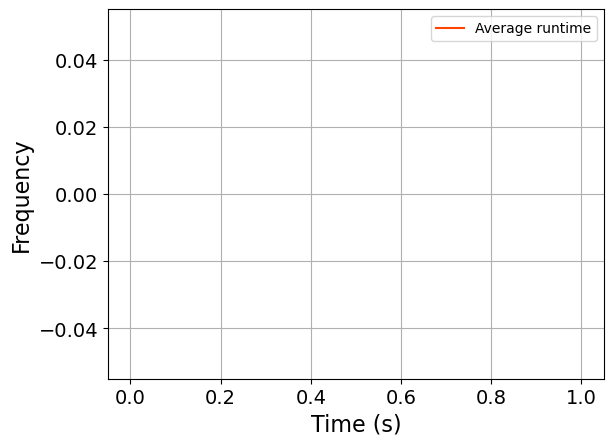

In [23]:
# Runtimes

plt.rc('xtick', labelsize = 14) 
plt.rc('ytick', labelsize = 14)
plt.axvline(x = average, color = 'orangered', label = 'Average runtime', zorder = 3)
plt.hist(times, bins = 10, zorder = 1, color = 'navy')
plt.grid(zorder = 0)
plt.xlabel('Time (s)', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.legend()
plt.show()

We plot a histogram of the average computation time for each simulation.

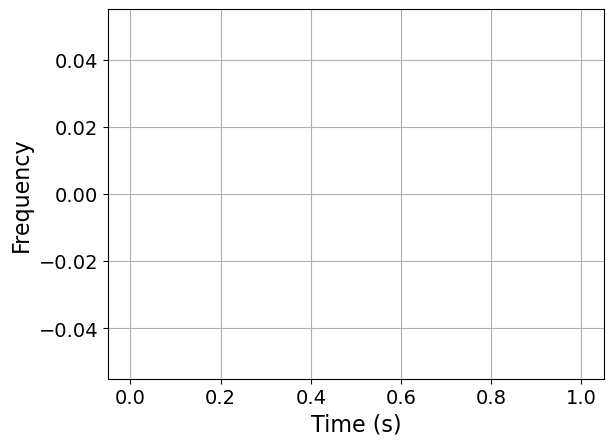

In [24]:
# Computation times

plt.rc('xtick', labelsize = 14) 
plt.rc('ytick', labelsize = 14)
plt.hist(runtimes, bins = 10, zorder = 0.002, color = 'navy')
plt.grid(zorder = 0)
plt.xlabel('Time (s)', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.show()

We plot x_hat - x to help us determine observability.

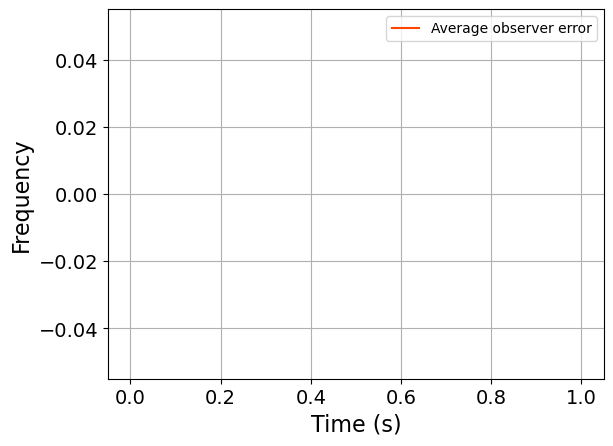

In [25]:
# Observer error

plt.rc('xtick', labelsize = 14) 
plt.rc('ytick', labelsize = 14)
plt.axvline(x = np.average(xhat_x), color = 'orangered', label = 'Average observer error', zorder = 3)
plt.hist(xhat_x, bins=10, color = 'navy')
plt.grid(zorder = 0)
plt.xlabel('Time (s)', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.legend()
plt.show()

We plot x - x_des to help us determine controllability.

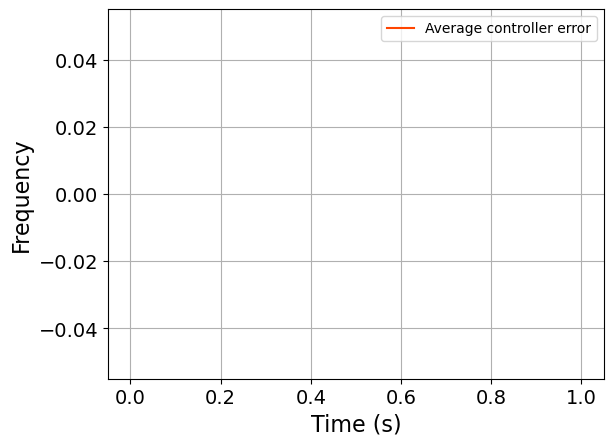

In [26]:
# Controller error

plt.rc('xtick', labelsize = 14) 
plt.rc('ytick', labelsize = 14)
plt.axvline(x = np.average(x_xdes), color = 'orangered', label = 'Average controller error', zorder = 3)
plt.hist(x_xdes, bins = 10, zorder = 0.002, color = 'navy')
plt.grid(zorder = 0)
plt.xlabel('Time (s)', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.legend()
plt.show()

# Trial 2: Same Course

In this trial, 200 simulations will be run with only one course and randomly generated initial conditions.

First, we create arrays to store the data we need for any plots and figures we'd like to make.

In [117]:
times_2 = np.array([])
xhat_x_2 = np.array([])
runtimes_2 = np.array([])
x_xdes_2 = np.array([])
fail_count_2 = 0

Next, we create the simulator environment. Note that the `seed` is set to 24, rather than being randomly generated.

In [118]:
simulator = ae353_drone.Simulator(
    display=False,
    display_pybullet=False,
    seed=24,
)

We run the simulation the number of times defined by `trials`.

In [119]:
dt = 0
for i in range(trials): 
    
    
    simulator.clear_drones()
    simulator.add_drone(Controller, 'template', 'template.png')
    simulator.reset()
    simulator.run(max_time=1000.)
    
    (
    did_it_fail,
    did_it_finish,
    what_time_did_it_finish,
    ) = simulator.get_result('template')
    
    data = simulator.get_data('template')
    
    dt = 0
    dt_candidate = np.array([])
    if did_it_fail:
        fail_count += 1
    elif did_it_finish:
        times_2 = np.append(times_2, what_time_did_it_finish)
        
        x = np.array([data['p_x'], data['p_y'], data['p_z'], data['yaw'], data['pitch'], data['roll'], data['v_x'], data['v_y'], data['v_z'], data['w_x'], data['w_y'], data['w_z']]).T
        xhat_x_2 = np.append(xhat_x_2, np.linalg.norm(data['xhat'] - x))
        
        runtimes_2 = np.append(runtimes_2, np.sqrt(np.mean((data['run_time'])**2)))#calculating the RMS of the runtime for each run
         
        control_t = 300 #12s
        for j in range(26):#searches for up to 1s away from original d
            dt_candidate = np.append(dt_candidate, np.linalg.norm(x[control_t + j]-data['xdes'][control_t]))

        dt = np.argmax(dt_candidate)

        p_des = data['xdes']
#         print(p_des[:(data['xdes'].size-dt)].size)
        x_xdes_2 = np.append(x_xdes_2, np.linalg.norm(x[dt:] - p_des[:data['xdes'].shape[0]-dt]))

test2
test3
0
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
20
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
40
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
60
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
80
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
100
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
120
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
test2
test3
140
te

In [121]:
print(f'Success rate: {times_2.size/trials * 100}%')
print()
print(f'Average runtime: {np.average(times_2)}')

average = np.average(times_2)

Success rate: 61.5%

Average runtime: 32.26113821138211


# Trial 2: Plots and Figures

We plot a histogram of the runtimes of each of the completed simulations.

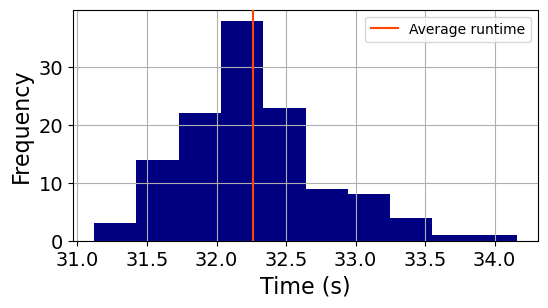

In [144]:
# Runtimes
fig = plt.figure(figsize=(6, 3))
axe = fig.gca()
plt.rc('xtick', labelsize = 14) 
plt.rc('ytick', labelsize = 14)
axe.axvline(x = average, color = 'orangered', label = 'Average runtime', zorder = 3)
axe.hist(times_2, bins = 10, zorder = 1, color = 'navy')
axe.grid(zorder = 0)
axe.set_xlabel('Time (s)', fontsize = 16)
axe.set_ylabel('Frequency', fontsize = 16)
axe.legend()
plt.show()
fig.savefig("runtime.pdf", facecolor='white', transparent=False, format="pdf", bbox_inches = 'tight')


We plot a histogram of the average computation time for each simulation.

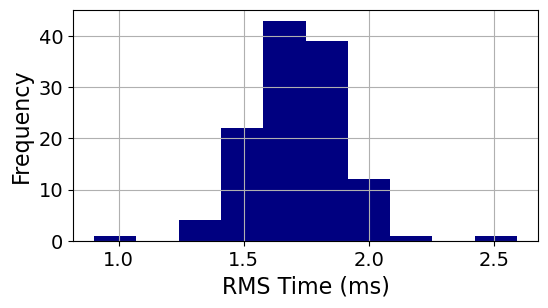

In [145]:
# Computation times

# plt.rc('xtick', labelsize = 14) 
# plt.rc('ytick', labelsize = 14)
# plt.hist(runtimes_2 * 1e3, bins = 10, zorder = 0.002, color = 'navy')
# plt.grid(zorder = 0)
# plt.xlabel('Time (ms)', fontsize = 16)
# plt.ylabel('Frequency', fontsize = 16)
# plt.show()

fig = plt.figure(figsize=(6, 3))
axe = fig.gca()
plt.rc('xtick', labelsize = 14) 
plt.rc('ytick', labelsize = 14)
axe.hist(runtimes_2 * 1e3, bins = 10, zorder = 0.002, color = 'navy')
axe.grid(zorder = 0)
axe.set_xlabel('RMS Time (ms)', fontsize = 16)
axe.set_ylabel('Frequency', fontsize = 16)
plt.show()
fig.savefig("compiletime.pdf", facecolor='white', transparent=False, format="pdf", bbox_inches = 'tight')

We plot x_hat - x to help us determine observability.

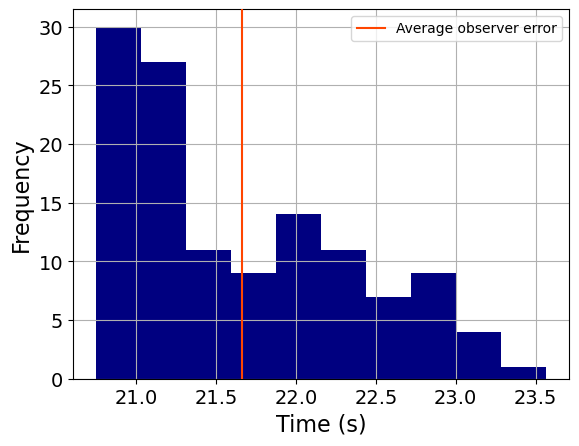

In [124]:
# Observer error

plt.rc('xtick', labelsize = 14) 
plt.rc('ytick', labelsize = 14)
plt.axvline(x = np.average(xhat_x_2), color = 'orangered', label = 'Average observer error', zorder = 3)
plt.hist(xhat_x_2, bins=10, color = 'navy')
plt.grid(zorder = 0)
plt.xlabel('Time (s)', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.legend()
plt.show()

We plot x - x_des to help us determine controllability.

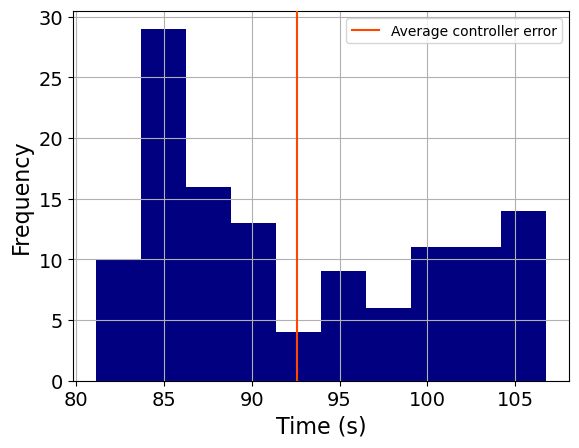

In [125]:
# Controller error

plt.rc('xtick', labelsize = 14) 
plt.rc('ytick', labelsize = 14)
plt.axvline(x = np.average(x_xdes_2), color = 'orangered', label = 'Average controller error', zorder = 3)
plt.hist(x_xdes_2, bins = 10, zorder = 0.002, color = 'navy')
plt.grid(zorder = 0)
plt.xlabel('Time (s)', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.legend()
plt.show()

# Failure Cases

The following trials are to plot data to test the failure cases.

In [ ]:
simulator = ae353_drone.Simulator(
    display=True,
    display_pybullet=False,
    seed=20, # secrets.randbits(32)
)

Add the drone, and set the camera to be on `droneview`.

In [ ]:
simulator.clear_drones()
simulator.add_drone(Controller, 'template', 'whenthestressisinvariant.jpg')
simulator.reset()
simulator.camera_droneview('template')

First, we set the number of simulations and initialize an array `times_3` to record the runtime for each simulation.

In [ ]:
trials = 100

times_3 = np.array([])
fail_count = 0

Run the simulation the number of times defined by `trials`.

In [ ]:
for i in range(trials): 
    
    x = -9.65  - secrets.randbits(3)*0.1
    y = 0.35 - secrets.randbits(3)*0.1
    simulator.clear_drones()
    simulator.add_drone(Controller, 'template', 'whenthestressisinvariant.jpg')
    simulator.reset( # Initial conditions set the drone near the middle of the circle
        initial_conditions={
            'template': {
                'p_x': x,
                'p_y': y,
                'p_z': 0.5,
                'yaw': 0.,
                'pitch': 0.,
                'roll': 0.,
                'v_x': 0.,
                'v_y': 0.,
                'v_z': 0.,
                'w_x': 0.,
                'w_y': 0.,
                'w_z': 0.,
                'p_x_meas': x,
                'p_y_meas': y,
                'p_z_meas': 0.5,
                'yaw_meas': 0.,
            },
        },
    )
    simulator.camera_droneview('template')
    simulator.run(max_time=1000.)
    
    (
    did_it_fail,
    did_it_finish,
    what_time_did_it_finish,
    ) = simulator.get_result('template')
    
    data = simulator.get_data('template')
    
    if did_it_fail:
        fail_count += 1
    elif did_it_finish:
        times_3 = np.append(times_3, what_time_did_it_finish)
        x = np.array([data['p_x'], data['p_y'], data['p_z'], data['yaw'], data['pitch'], data['roll'], data['v_x'], data['v_y'], data['v_z'], data['w_x'], data['w_y'], data['w_z']]).T
        
    if (np.mod(i, 20) == 0):
        print(i)

print('COMPLETE')

Print the success rate and average runtime of the simulations.

In [ ]:
print(f'Success rate: {times_3.size/trials * 100}%')
print()
print(f'Average runtime: {np.average(times_3)}')

times_3

Initialize the array to record runtimes for the fourth trial.

In [ ]:
times_4 = np.array([])
fail_count = 0

Run the simulation the number of times defined by `trials`.

In [ ]:
for i in range(trials): 
    
    x = -8.775  - secrets.randbits(3)*0.35
    y = 1.225 - secrets.randbits(3)*0.35
    simulator.clear_drones()
    simulator.add_drone(Controller, 'template', 'whenthestressisinvariant.jpg')
    simulator.reset( # Initial conditions set the drone anywhere in the circle
        initial_conditions={
            'template': {
                'p_x': x,
                'p_y': y,
                'p_z': 0.5,
                'yaw': 0.,
                'pitch': 0.,
                'roll': 0.,
                'v_x': 0.,
                'v_y': 0.,
                'v_z': 0.,
                'w_x': 0.,
                'w_y': 0.,
                'w_z': 0.,
                'p_x_meas': x,
                'p_y_meas': y,
                'p_z_meas': 0.5,
                'yaw_meas': 0.,
            },
        },
    )
    simulator.run(max_time=1000.)
    
    (
    did_it_fail,
    did_it_finish,
    what_time_did_it_finish,
    ) = simulator.get_result('template')
    
    data = simulator.get_data('template')
    
    if did_it_fail:
        fail_count += 1
    elif did_it_finish:
        times_4 = np.append(times_4, what_time_did_it_finish)
        x = np.array([data['p_x'], data['p_y'], data['p_z'], data['yaw'], data['pitch'], data['roll'], data['v_x'], data['v_y'], data['v_z'], data['w_x'], data['w_y'], data['w_z']]).T
        
    if (np.mod(i, 20) == 0):
        print(i)

print('COMPLETE')

Print the success rate and average runtime of the simulations.

In [ ]:
print(f'Success rate: {times_4.size/trials * 100}%')
print()
print(f'Average runtime: {np.average(times_3)}')

times_4

# Other Plots

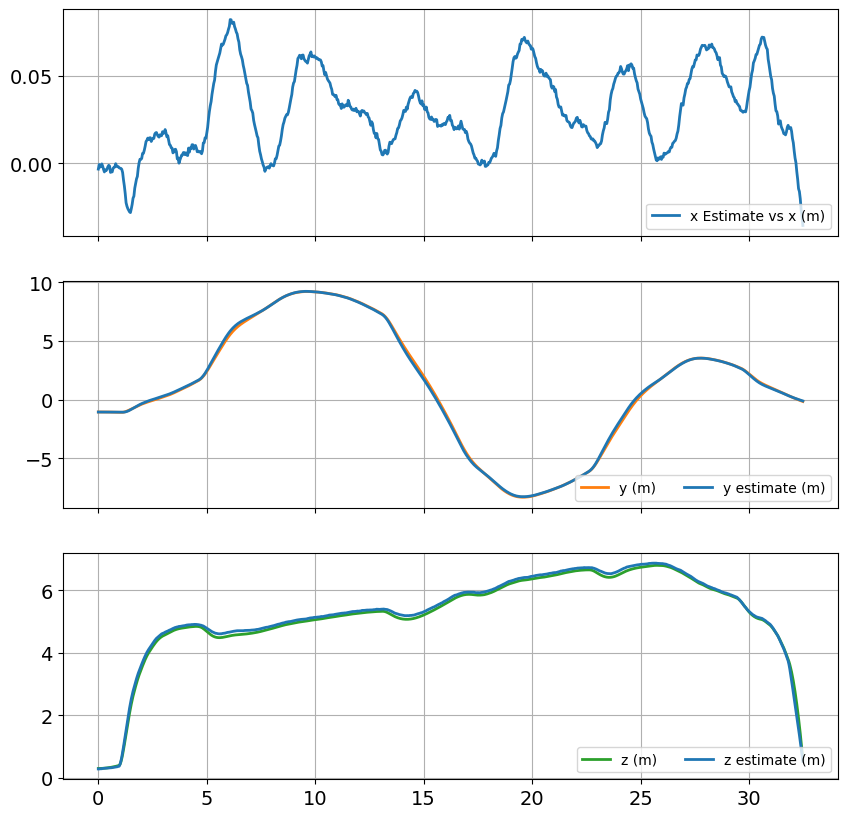

In [126]:
fig, (ax_px, ax_py, ax_pz) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

ax_px.plot(data['t'], data['xhat'][:,0]-data['p_x'], label='x Estimate vs x (m)', linewidth=2)
ax_px.grid()
ax_px.legend(fontsize=10, ncol=3, loc='lower right')
ax_px.tick_params(labelsize=14)
ax_py.plot(data['t'], data['p_y'], label='y (m)', linewidth=2, color='C1')
ax_py.plot(data['t'], data['xhat'][:,1], label='y estimate (m)', linewidth=2)
ax_py.grid()
ax_py.legend(fontsize=10, ncol=3, loc='lower right')
ax_py.tick_params(labelsize=14)
ax_pz.plot(data['t'], data['p_z'], label='z (m)', linewidth=2, color='C2')
ax_pz.plot(data['t'], data['xhat'][:,2], label='z estimate (m)', linewidth=2)
ax_pz.grid()
ax_pz.legend(fontsize=10, ncol=3, loc='lower right')
ax_pz.tick_params(labelsize=14)

In [127]:
simulator = ae353_drone.Simulator(
    display=True,
    display_pybullet=False,
    seed=secrets.randbits(32),
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [128]:
simulator.clear_drones()
simulator.add_drone(Controller, 'template', 'whenthestressisinvariant.jpg')
simulator.reset()
simulator.camera_droneview('template')
simulator.run(max_time=1000.,print_debug=True)


drone template is inactive (turning it off)

Simulated 256 time steps in 10.2564 seconds (24.9601 time steps per second)


The drone failed before finishing.


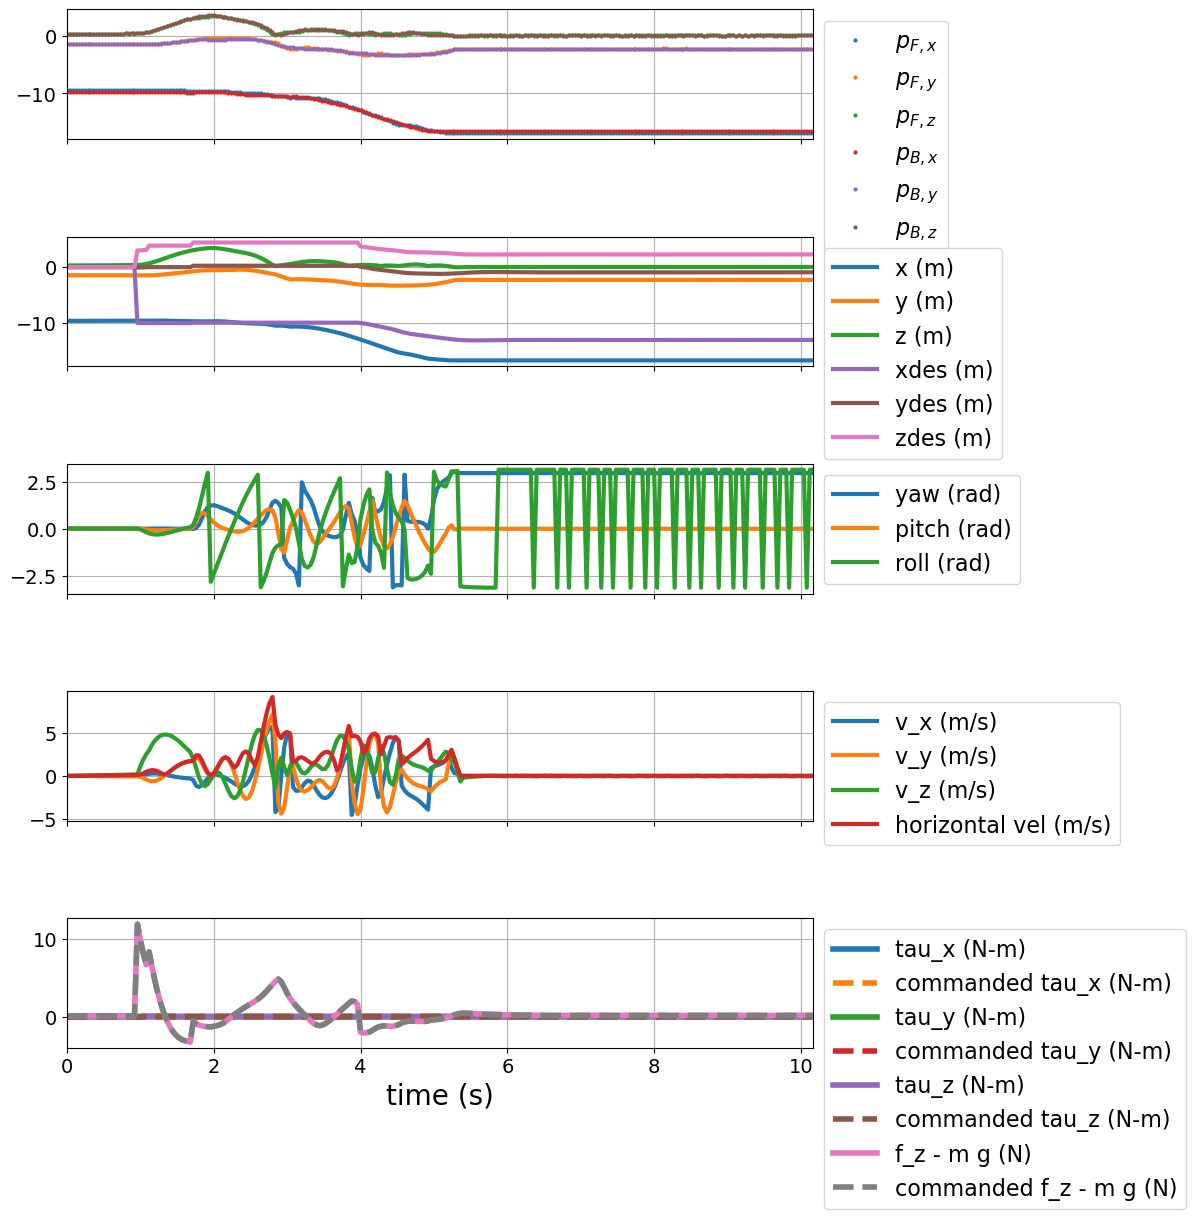

In [129]:
(
    did_it_fail,
    did_it_finish,
    what_time_did_it_finish,
) = simulator.get_result('template')
if did_it_fail:
    print('The drone failed before finishing.')
elif did_it_finish:
    print(f'The drone finished at time {what_time_did_it_finish}')
else:
    print('The drone did not finish (yet).')
data = simulator.get_data('template')
# Create a figure with subplots that all share the same x-axis
fig, (ax_meas, ax_pos, ax_ori, ax_vel, ax_act) = plt.subplots(5, 1, figsize=(12, 12), sharex=True)

# Measurements
ax_meas.plot(data['t'], data['pos_markers'][:, 0], '.', markersize=4, label=r'$p_{F, x}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 1], '.', markersize=4, label=r'$p_{F, y}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 2], '.', markersize=4, label=r'$p_{F, z}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 3], '.', markersize=4, label=r'$p_{B, x}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 4], '.', markersize=4, label=r'$p_{B, y}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 5], '.', markersize=4, label=r'$p_{B, z}$')
ax_meas.grid()
ax_meas.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_meas.tick_params(labelsize=14)

# Position
ax_pos.plot(data['t'], data['p_x'], label='x (m)', linewidth=3, color='C0')
ax_pos.plot(data['t'], data['p_y'], label='y (m)', linewidth=3, color='C1')
ax_pos.plot(data['t'], data['p_z'], label='z (m)', linewidth=3, color='C2')
ax_pos.plot(data['t'], data['xdes'][:,0], label='xdes (m)', linewidth=3, color='C4')
ax_pos.plot(data['t'], data['xdes'][:,1], label='ydes (m)', linewidth=3, color='C5')
ax_pos.plot(data['t'], data['xdes'][:,2], label='zdes (m)', linewidth=3, color='C6')
ax_pos.grid()
ax_pos.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_pos.tick_params(labelsize=14)

# Orientation
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=3)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=3)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=3)
ax_ori.grid()
ax_ori.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_ori.tick_params(labelsize=14)

ax_vel.plot(data['t'], data['v_x'], label='v_x (m/s)', linewidth=3)
ax_vel.plot(data['t'], data['v_y'], label='v_y (m/s)', linewidth=3)
ax_vel.plot(data['t'], data['v_z'], label='v_z (m/s)', linewidth=3)
ax_vel.plot(data['t'], np.sqrt(data['v_x']**2 + data['v_y']**2), label='horizontal vel (m/s)', linewidth=3)
ax_vel.grid()
ax_vel.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_vel.tick_params(labelsize=14)

# Actuator commands
ax_act.plot(data['t'], data['tau_x'], label='tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_x_cmd'], '--', label='commanded tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y'], label='tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y_cmd'], '--', label='commanded tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z'], label='tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z_cmd'], '--', label='commanded tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['f_z'] - (0.5 * 9.81), label='f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.plot(data['t'], data['f_z_cmd'] - (0.5 * 9.81), '--', label='commanded f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.grid()
ax_act.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_act.tick_params(labelsize=14)

# Set shared x-axis properties
ax_act.set_xlabel('time (s)', fontsize=20)
ax_act.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()
plt.show()

[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
-2.999965110628028


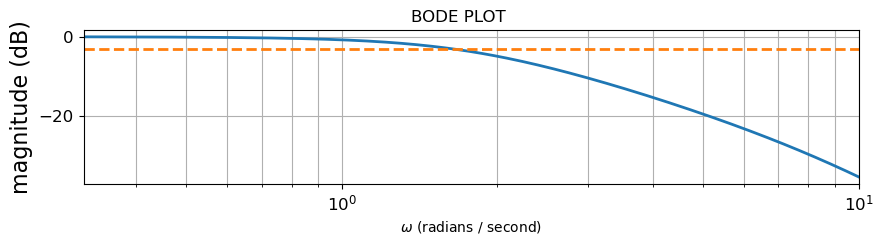

In [64]:
#Bode Plot X

Am = np.block([[A    , -B @ K           ],
               [L @ C, A - B @ K - L @ C]])

e_1 = np.zeros((12,1))
e_1[0][0] = 1.
Bm = np.block([[B @ K @ e_1],
               [B @ K @ e_1]])

Cm = np.block([[e_1.T, np.zeros((1, A.shape[0]))]])
H = lambda s: (Cm @ linalg.inv(s * np.eye(Am.shape[0]) - Am) @ Bm).item()

print(e_1)
print(20*np.log10(np.absolute(H(1j*1.61893))))

omega = np.logspace(-0.5, 1, 250)
H_at_jomega = np.empty_like(omega, dtype=complex)
for i in range(len(omega)):
    H_at_jomega[i] = H(1j * omega[i])
mag = np.absolute(H_at_jomega)
ang = np.angle(H_at_jomega)

mag_in_dB = 20. * np.log10(mag)
ang_in_deg = np.rad2deg(ang)

fig, (ax_mag) = plt.subplots(1, 1, figsize=(10, 2), sharex=True)
ax_mag.semilogx(omega, mag_in_dB, linewidth=2)
ax_mag.semilogx(omega, -3. * np.ones_like(omega), '--', linewidth=2)
ax_mag.grid(visible=True, which='both', axis='both')
ax_mag.tick_params(labelsize=12)
ax_mag.yaxis.set_major_locator(MultipleLocator(20))
ax_mag.set_ylabel('magnitude (dB)', fontsize=16)
# ax_ang.semilogx(omega, ang_in_deg, linewidth=2)
# ax_ang.grid(visible=True, which='both', axis='both')
# ax_ang.tick_params(labelsize=12)
# ax_ang.yaxis.set_major_locator(MultipleLocator(45))
# ax_ang.set_ylabel('angle (degrees)', fontsize=16)
# ax_ang.set_ylim([-180, 180])
ax_mag.set_xlim([min(omega), max(omega)])
ax_mag.set_xlabel(r'$\omega$ (radians / second)')
fig.suptitle('BODE PLOT')
plt.show()

[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
-2.9999651106282665


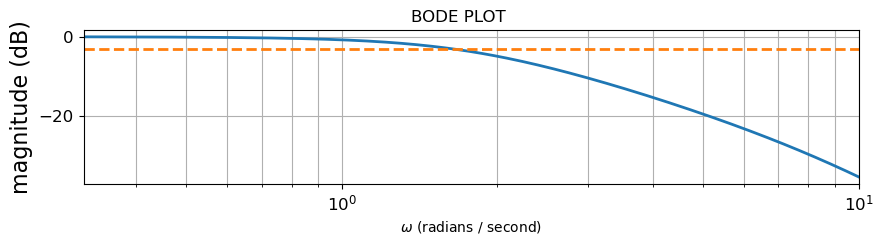

In [65]:
e_1 = np.zeros((12,1))
e_1[1][0] = 1.
Bm = np.block([[B @ K @ e_1],
               [B @ K @ e_1]])

Cm = np.block([[e_1.T, np.zeros((1, A.shape[0]))]])
H = lambda s: (Cm @ linalg.inv(s * np.eye(Am.shape[0]) - Am) @ Bm).item()

print(e_1)
print(20*np.log10(np.absolute(H(1j*1.61893))))

omega = np.logspace(-0.5, 1, 250)
H_at_jomega = np.empty_like(omega, dtype=complex)
for i in range(len(omega)):
    H_at_jomega[i] = H(1j * omega[i])
mag = np.absolute(H_at_jomega)
ang = np.angle(H_at_jomega)

mag_in_dB = 20. * np.log10(mag)
ang_in_deg = np.rad2deg(ang)

fig, (ax_mag) = plt.subplots(1, 1, figsize=(10, 2), sharex=True)
ax_mag.semilogx(omega, mag_in_dB, linewidth=2)
ax_mag.semilogx(omega, -3. * np.ones_like(omega), '--', linewidth=2)
ax_mag.grid(visible=True, which='both', axis='both')
ax_mag.tick_params(labelsize=12)
ax_mag.yaxis.set_major_locator(MultipleLocator(20))
ax_mag.set_ylabel('magnitude (dB)', fontsize=16)
# ax_ang.semilogx(omega, ang_in_deg, linewidth=2)
# ax_ang.grid(visible=True, which='both', axis='both')
# ax_ang.tick_params(labelsize=12)
# ax_ang.yaxis.set_major_locator(MultipleLocator(45))
# ax_ang.set_ylabel('angle (degrees)', fontsize=16)
# ax_ang.set_ylim([-180, 180])
ax_mag.set_xlim([min(omega), max(omega)])
ax_mag.set_xlabel(r'$\omega$ (radians / second)')
fig.suptitle('BODE PLOT')
plt.show()

[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
-0.4098618573081536


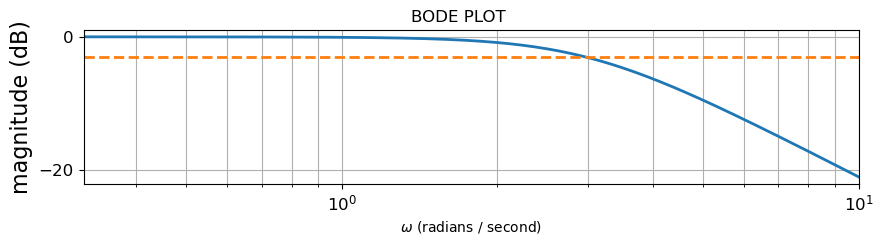

In [66]:
e_1 = np.zeros((12,1))
e_1[2][0] = 1.
Bm = np.block([[B @ K @ e_1],
               [B @ K @ e_1]])

Cm = np.block([[e_1.T, np.zeros((1, A.shape[0]))]])
H = lambda s: (Cm @ linalg.inv(s * np.eye(Am.shape[0]) - Am) @ Bm).item()

print(e_1)
print(20*np.log10(np.absolute(H(1j*1.61893))))

omega = np.logspace(-0.5, 1, 250)
H_at_jomega = np.empty_like(omega, dtype=complex)
for i in range(len(omega)):
    H_at_jomega[i] = H(1j * omega[i])
mag = np.absolute(H_at_jomega)
ang = np.angle(H_at_jomega)

mag_in_dB = 20. * np.log10(mag)
ang_in_deg = np.rad2deg(ang)

fig, (ax_mag) = plt.subplots(1, 1, figsize=(10, 2), sharex=True)
ax_mag.semilogx(omega, mag_in_dB, linewidth=2)
ax_mag.semilogx(omega, -3. * np.ones_like(omega), '--', linewidth=2)
ax_mag.grid(visible=True, which='both', axis='both')
ax_mag.tick_params(labelsize=12)
ax_mag.yaxis.set_major_locator(MultipleLocator(20))
ax_mag.set_ylabel('magnitude (dB)', fontsize=16)
# ax_ang.semilogx(omega, ang_in_deg, linewidth=2)
# ax_ang.grid(visible=True, which='both', axis='both')
# ax_ang.tick_params(labelsize=12)
# ax_ang.yaxis.set_major_locator(MultipleLocator(45))
# ax_ang.set_ylabel('angle (degrees)', fontsize=16)
# ax_ang.set_ylim([-180, 180])
ax_mag.set_xlim([min(omega), max(omega)])
ax_mag.set_xlabel(r'$\omega$ (radians / second)')
fig.suptitle('BODE PLOT')
plt.show()

In [69]:
simulator.clear_drones()
failures = simulator.load_drones()
simulator.reset()
simulator.run(max_time=5.0)

Try to import controllers from the directory "./students":
 ./students/eylim3.py
 ./students/template.py


The following controllers failed to import and were ignored:

